In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns
sns.set_theme(style="darkgrid")

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
EXTERNAL_LIBS_PATH = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
sys.path.insert(1, EXTERNAL_LIBS_PATH)

# Load cortum libs
import NN_interpretability as nn_inter
import Data_augmentation as data_aug
import tfds_utils

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Set parameters
params = {}
params['base_path'] = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability'
params['model_dirs'] = {
    'BL_RIV2_test4': '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/BL_RIV2_test4',}
params['CMA'] = 'CMA_0'
params['cells'] = ['258520', '208516', '262920', '307720']
params['tf_ds_name'] = 'mpp_ds_normal_dmso_z_score'
params['local_tf_datasets'] = '/data/Master_Thesis_data/datasets/tensorflow_datasets'

plot_dir = os.path.join(params['base_path'], 'Plots')
os.makedirs(plot_dir, exist_ok=True)

# Notas
- BL_t8 mide 08_H3K4ME3 usando 09_SRRM2
- It looks like cell 277420 is 2 overlaped cells.

## 1.1.- Load dataset

In [4]:
# Path where tf datasets are
dataset, ds_info = tfds.load(
    name=params['tf_ds_name'], 
    data_dir=params['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

# Load splits
train_data, val_data = dataset['train'], dataset['validation']

In [5]:
ds_info.splits

{'test': <tfds.core.SplitInfo num_examples=371>,
 'train': <tfds.core.SplitInfo num_examples=2962>,
 'validation': <tfds.core.SplitInfo num_examples=370>}

In [6]:
ds_info.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 38), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

In [7]:
tfds_metadata['metadata_df']

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg,cell_size_ratio,set
0,263042,263055,plate01,J16,0,0,0,0,4,0,plate01,J16,0,0,0,0,4,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,8401.0,39.610201,282.212391,14.709787,34.481345,122.127518,29.408288,48.079878,56.508154,71.844750,93.999276,108.771761,157.808500,85.331438,43.616172,323.670767,128.386167,134.658031,18.805303,57.414965,26.659837,122.008728,35.669525,62.715594,133.643428,77.230008,283.199741,6.970504,92.891114,280.267874,41.649294,350.631178,356.940289,10.909557,8.600135,1.771257,431.543626,7754.927152,9285.622307,0.553571,train
1,263043,263056,plate01,J16,0,0,0,0,5,0,plate01,J16,0,0,0,0,5,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,12207.0,34.884746,249.743762,14.587963,33.729957,104.787060,25.446742,35.599046,54.977671,48.061287,90.354757,97.722536,145.751775,95.141995,43.284735,308.379265,118.856662,125.728553,14.722060,52.481306,21.451844,122.747143,30.401393,53.993867,124.670275,81.619971,272.290742,9.256049,120.165421,267.314880,39.224038,322.807908,387.219828,10.134157,7.880916,1.749512,461.474236,8818.934136,11041.621938,0.598214,test
2,263044,263057,plate01,J16,0,0,0,0,6,0,plate01,J16,0,0,0,0,6,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,DMSO,720.0,15734.0,31.429217,184.722779,7.892179,19.263491,81.864454,23.929299,29.536900,39.606383,39.047856,77.348039,12.910413,149.859577,42.855445,25.530594,219.118552,102.575527,125.740665,5.120140,27.724444,24.187370,49.106275,29.276163,35.680201,85.295744,60.602490,232.305672,8.395510,124.383677,193.414682,36.115297,273.154826,252.115717,7.854372,8.116748,1.803605,372.570739,5740.956972,7330.808440,0.723214,train
3,263045,263058,plate01,J16,0,0,0,0,7,0,plate01,J16,0,0,0,0,7,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,15767.0,43.349090,241.460906,18.110119,44.601291,122.976267,40.604674,48.760110,58.076779,77.012867,121.283321,104.755645,159.792550,84.807594,43.961097,319.584115,120.314566,120.470444,25.555966,60.243330,21.220701,140.246102,27.944981,60.354207,169.718381,102.371663,264.648847,10.370258,116.424263,268.396552,43.573547,351.399875,357.762600,10.338172,7.913029,1.773024,369.910382,8085.528636,9678.381810,0.660714,test
4,263047,263060,plate01,J16,0,0,0,0,9,0,plate01,J16,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,DMSO,720.0,11930.0,28.164459,149.241408,27.710272,72.874109,148.002903,51.391368,56.976488,116.255474,56.907744,66.943473,97.452245,187.995952,53.530015,60.917580,134.426297,121.980833,121.369045,59.501243,54.852952,26.389251,162.722979,36.026263,79.981471,237.625004,150.247531,255.964144,18.029298,188.560486,192.446750,66.494555,242.252349,174.614508,9.784177,8.899475,1.970130,552.887343,15128.646940,13469.590947,0.625000,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,266516,266565,plate01,J12,5,4,0,0,44,0,plate01,J12,5,4,0,0,44,0,0.0,NaN,0.0,NaN,0.0,NaN,G2,184A1,normal,NaN,19401.0,38.974759,76.047797,17.563898,36.

In [8]:
# take a look into the bigger cels also
big_cells = tfds_metadata['metadata_df'].sort_values(by='cell_size_ratio', ascending=False).head(21)[['mapobject_id_cell']]
big_cells = big_cells.values.reshape(-1).astype('str')

In [9]:
channels_df = tfds_metadata['channels_df']
channel_names = [c.split("_")[1:] for c in channels_df.name.values]
channel_names = ["_".join(c) for c in channel_names]
channels_df['channel_name'] = channel_names
channels_df

,original_channel_id,name,train_98_percentile,train_mean_after_clipping,train_stddev_after_clipping,type,TFDS_channel_id,channel_name
0,0.0,00_DAPI,69.300003,29.277029,14.289816,input,0.0,DAPI
1,1.0,07_H2B,310.299988,128.472672,67.600372,input,1.0,H2B
2,2.0,01_CDK9_pT186,46.889076,10.841645,10.662010,input,2.0,CDK9_pT186
3,3.0,03_CDK9,90.797798,24.890778,20.744143,input,3.0,CDK9
4,4.0,05_GTF2B,188.166107,76.841652,45.399426,input,4.0,GTF2B
5,5.0,07_SETD1A,91.989853,20.670820,20.641857,input,5.0,SETD1A
6,6.0,08_H3K4me3,105.921074,34.419682,24.227314,input,6.0,H3K4me3
7,7.0,09_SRRM2,273.374664,39.124294,58.492748,input,7.0,SRRM2
8,8.0,10_H3K27ac,175.104874,59.614319,42.007408,input,8.0,H3K27ac
9,9.0,11_KPNA2_MAX,115.093430,41.293499,23.342470,input,9.0,KPNA2_MAX


In [10]:
# Load model parameters
temp_key = list(params['model_dirs'].keys())[0]
temp_path = os.path.join(params['model_dirs'][temp_key], 'parameters.json')
with open(temp_path, 'r') as file:
    model_params = json.load(file)
print(model_params.keys())

dict_keys(['parameters_file_path', 'external_libs_path', 'model_name', 'custom_model_class', 'pre_training', 'dense_reg', 'conv_reg', 'bias_l2_reg', 'number_of_epochs', 'early_stop_patience', 'loss', 'learning_rate', 'BATCH_SIZE', 'verbose_level', 'model_path', 'basename', 'base_path', 'clean_model_dir', 'tf_ds_name', 'input_channels', 'shuffle_files', 'local_tf_datasets', 'random_horizontal_flipping', 'random_90deg_rotations', 'CenterZoom', 'CenterZoom_mode', 'Random_channel_intencity', 'RCI_dist', 'RCI_mean', 'RCI_stddev', 'RCI_rescale_cte', 'log_path', 'log_file', 'tensorboard', 'seed', 'disable_gpu', 'set_memory_growth', 'cell_size_ratio_mean', 'cell_size_ratio_stddev', 'cell_size_ratio_low_bound'])


In [11]:
# Get input_ids
selected_channels = model_params['input_channels']
n_channels = len(selected_channels)
input_ids = np.array(channels_df.set_index(['name']).loc[selected_channels].TFDS_channel_id.values)
input_ids = np.sort(input_ids.astype(np.int16))
input_channel_names = channels_df.sort_values(by='TFDS_channel_id').set_index('TFDS_channel_id').loc[range(n_channels)].name.values
msg = 'Input channel ids:\n{}'.format(input_ids)
print(msg)

Input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


## 1.2.- Load Model Data

In [12]:
#models_path = os.path.join(params['base_path'], 'Models', params['model_dir'])
targets_df = pd.DataFrame()
for i, model in enumerate(params['model_dirs'].keys()):
    model_dir = params['model_dirs'][model]
    print('Reading predicted values for model: ', model)
    temp_path = os.path.join(model_dir, 'targets_'+params['CMA']+'.csv')
    with open(temp_path, 'r') as file:
        temp_df = pd.read_csv(file)
    temp_df = temp_df.drop(['y - y_hat'], axis=1)
    prediction_name = 'y_hat'+'_'+model
    temp_df[prediction_name] = temp_df.y_hat
    temp_df = temp_df.drop(['y_hat'], axis=1)
    if i == 0:
        targets_df = temp_df.copy()
    else:
        temp_df = temp_df[['mapobject_id_cell', prediction_name]]
        targets_df = targets_df.merge(temp_df, 
                                      left_on='mapobject_id_cell',
                                      right_on='mapobject_id_cell',
                                      how='left')
targets_df.mapobject_id_cell = targets_df.mapobject_id_cell.astype('string')
mask = targets_df.mapobject_id_cell.isin(np.array(params['cells']))
round(targets_df[mask], 2)

Reading predicted values for model:  BL_RIV2_test4


,y,mapobject_id_cell,set,perturbation,cell_cycle,y_hat_BL_RIV2_test4
18,169.75,258520,train,normal,G1,280.56
2934,513.50,262920,train,normal,G2,497.50
3129,400.17,208516,val,normal,S,418.22
3133,366.16,307720,val,DMSO,G1,331.48


## 1.3.- Load Model

In [13]:
# Load model
model_name = 'BL_RIV2_test4'
temp_path = os.path.join(params['model_dirs'][model_name], 'model',params['CMA'])
model = tf.keras.models.load_model(temp_path)
msg = '\nModel loaded successfully:\n'
print(msg)
model.summary()


Model loaded successfully:

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 224, 224, 33)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Ba

## 1.4.- Load a sample of cells

Opening cell: 258520, 1/4
['train']


Opening cell: 262920, 2/4
['train']


Opening cell: 208516, 3/4
['val']
Opening cell: 307720, 4/4
['val']


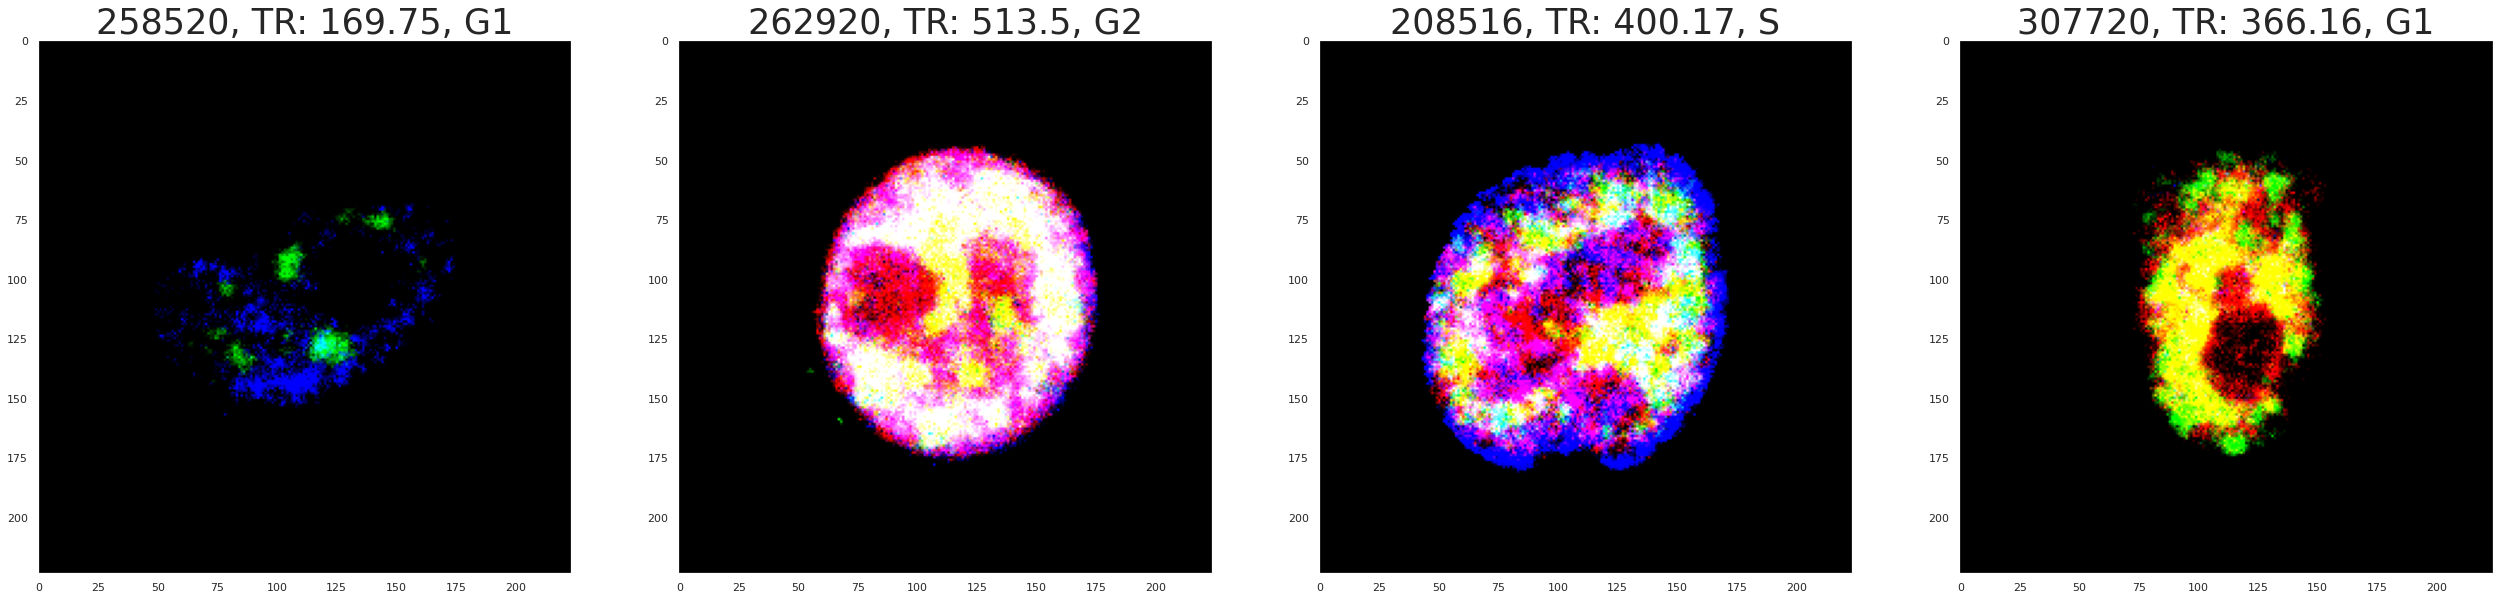

In [14]:
# Load cell, compute its Score map and save it
#params['cells'] = big_cells
n_cells = len(params['cells'])
big_cells
plt.figure(figsize=(n_cells*11,10))
dss = [train_data, val_data]
ds_names = ['train', 'val']
cell_count = 0
cells = {}
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in params['cells']:
            cell_count += 1
            print('Opening cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cells[cell_id+'_img'] = cell['image'].numpy()
            cells[cell_id+'_img'] = cells[cell_id+'_img'][:,:,input_ids].astype(np.float32)
            
            cells[cell_id+'_mask'] = cell['image'].numpy()
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'][:,:,-1]
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'].astype(np.bool)
            
            cells[cell_id+'_target'] = cell['target'].numpy()[0]
            
            # Plot cells
            temp_img = cells[cell_id+'_img'][:,:,10:13]
            plt.subplot(1, n_cells, cell_count)

            # Get TR
            TR = cells[cell_id+'_target']
            # get cc
            mask = targets_df.mapobject_id_cell == cell_id
            cc = targets_df[mask].cell_cycle.values[0]
            print(targets_df[mask].set.values)

            nn_inter.plot_cell(img=temp_img, title=cell_id+', TR: '+str(round(TR, 2))+', '+cc, title_fontsize=35)

In [15]:
import NN_interpretability

def get_integrated_gradients(baseline, image, model, m_steps=50, batch_size=32):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Initialize TensorArray outside loop to collect gradients.
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]
        
        #print(alpha, from_, to, alpha_batch)
        #print("")

        # 2. Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = NN_interpretability.interpolate_images(baseline=baseline,
                                                           image=image,
                                                           alphas=alpha_batch)

        # 3. Compute gradients between model outputs and interpolated inputs.
        gradient_batch = NN_interpretability.compute_gradients(images=interpolated_path_input_batch,
                                           model=model)

        # Write batch indices and gradients to extend TensorArray.
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)
        
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()
    #print(total_gradients.shape)

    # 4. Integral approximation through averaging gradients.
    avg_gradients = get_integral_approximation(gradients=total_gradients)

    # 5. Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

def get_integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)

    return integrated_gradients

In [16]:
cell_id = params['cells'][0]
cell_img = copy.deepcopy(cells[cell_id+'_img'])
cell_mask = copy.deepcopy(cells[cell_id+'_mask'])
cell_tr = cells[cell_id+'_target']

bl = tf.zeros(shape=cell_img.shape)
IG_m_steps = 70

ig_temp = get_integrated_gradients(baseline=bl,
                                   image=cell_img,
                                   model=model,
                                   m_steps=IG_m_steps
                                  )

In [17]:
alphas = tf.linspace(start=0.0, stop=1.0, num=IG_m_steps+1)
interpolated_images = NN_interpretability.interpolate_images(baseline=bl,
                                                           image=cell_img,
                                                           alphas=alphas)

path_gradients = NN_interpretability.compute_gradients(images=interpolated_images, model=model)

pred = model(interpolated_images)
pred_errors = tf.constant([cell_tr], shape=pred.shape, dtype=tf.float32) - pred
pred_errors = tf.math.abs(pred_errors)

In [18]:
def get_IG_sum(image, baseline, gradients):
    
    for i in range(2, gradients.shape[0]):
        # Integral approximation through averaging gradients.
        avg_gradients = get_integral_approximation(gradients=gradients[0:i])

        # Scale integrated gradients with respect to input.
        integrated_gradients = (image - baseline) * avg_gradients
        
        ig_sum = tf.reduce_sum(integrated_gradients, axis=[0,1,2])
        ig_sum = tf.reshape(ig_sum, shape=[1])
        
        if i == 2:
            #print(ig_sum)
            ig_sums = tf.identity(ig_sum)
        else:
            ig_sums = tf.concat([ig_sums, ig_sum], axis=0)
        #print(ig_sums)

    return ig_sums

ig_sums = get_IG_sum(image=cell_img, baseline=bl, gradients=path_gradients)
ig_sums.shape

TensorShape([69])

Text(0.5, 0, 'alpha')

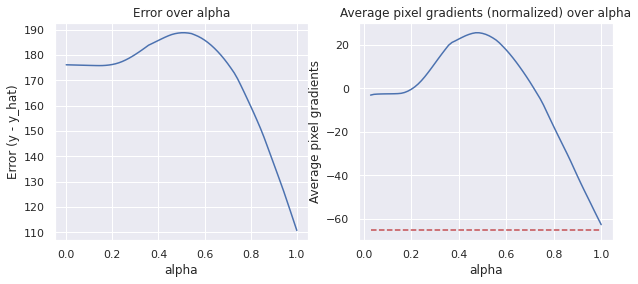

In [19]:

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_errors)
ax1.set_title('Error over alpha')
ax1.set_ylabel('Error (y - y_hat)')
ax1.set_xlabel('alpha')
#ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
#average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
#ax2.plot(alphas, average_grads_norm)
ax2.plot(alphas[2:], ig_sums)

temp_tensor = tf.expand_dims(cell_img, axis=0)
y = model(temp_tensor)
temp_tensor = tf.expand_dims(bl, axis=0)
y_hat = model(temp_tensor)
cte_val = (y - y_hat).numpy()[0][0]
horiz_line_data = np.array(len(alphas[2:]) * [cte_val])
ax2.plot(alphas[2:], horiz_line_data, 'r--') 

ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
#ax2.set_ylim([0, 1]);

Text(0.5, 0, 'alpha')

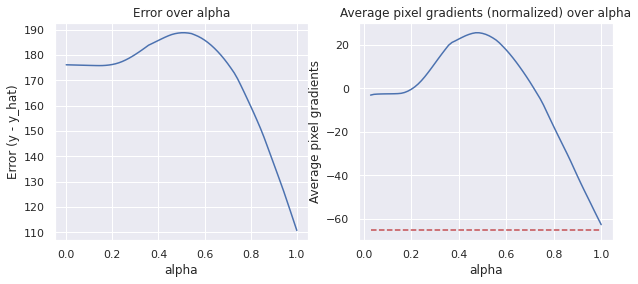

In [28]:

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_errors)
ax1.set_title('Error over alpha')
ax1.set_ylabel('Error (y - y_hat)')
ax1.set_xlabel('alpha')
#ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
#average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
#ax2.plot(alphas, average_grads_norm)
ax2.plot(alphas[2:], ig_sums)

temp_tensor = tf.expand_dims(cell_img, axis=0)
y = model(temp_tensor)
temp_tensor = tf.expand_dims(bl, axis=0)
y_hat = model(temp_tensor)
cte_val = (y - y_hat).numpy()[0][0]
horiz_line_data = np.array(len(alphas[2:]) * [cte_val])
ax2.plot(alphas[2:], horiz_line_data, 'r--') 

ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
#ax2.set_ylim([0, 1]);

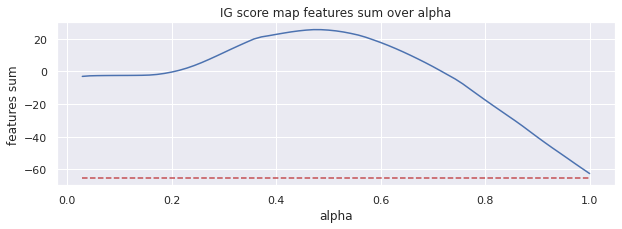

In [40]:
plt.figure(figsize=(10, 3))

# Average across interpolation steps
#average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
average_grads = tf.reduce_sum(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
#average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
#ax2.plot(alphas, average_grads_norm)
plt.plot(alphas[2:], ig_sums)

temp_tensor = tf.expand_dims(cell_img, axis=0)
y = model(temp_tensor)
temp_tensor = tf.expand_dims(bl, axis=0)
y_hat = model(temp_tensor)
cte_val = (y - y_hat).numpy()[0][0]
horiz_line_data = np.array(len(alphas[2:]) * [cte_val])
plt.plot(alphas[2:], horiz_line_data, 'r--') 

plt.title('IG score map features sum over alpha')
plt.ylabel('features sum')
plt.xlabel('alpha')
fig_name = "./" + "sanity_check_for_m.jpg"
plt.savefig(fig_name, bbox_inches='tight', pad_inches=0)

In [21]:
def normalize_img(img, img_mask):
    temp_img = copy.deepcopy(img)
    # make anything outside the cell 0
    temp_img[~img_mask] = 0
    min_val = np.min(temp_img[img_mask], axis=0)
    max_val = np.max(temp_img[img_mask], axis=0)

    temp_img[img_mask] = (temp_img[img_mask] - min_val) / (max_val - min_val)
    
    return temp_img

cell_id = params['cells'][0]
cell_img = copy.deepcopy(cells[cell_id+'_img'])
cell_mask = copy.deepcopy(cells[cell_id+'_mask'])
cell_tr = cells[cell_id+'_target']

bl = tf.zeros(shape=cell_img.shape)
IG_m_steps = 70
VarGrad_n_samples = 40

# get cell img gradients
temp_tensor = tf.constant(cell_img, dtype=tf.float32)
temp_tensor = tf.expand_dims(temp_tensor, axis=0)
img_grad = NN_interpretability.compute_gradients(images=temp_tensor, model=model)
img_grad = img_grad.numpy()
img_grad = img_grad[0]

# get cell img IG
img_ig = get_integrated_gradients(baseline=bl,
                                   image=cell_img,
                                   model=model,
                                   m_steps=IG_m_steps
                                  )
img_ig = img_ig.numpy()

# Get cell img vargrad
temp_mask = copy.deepcopy(cell_mask)
temp_mask = np.repeat(temp_mask[:,:,None], len(input_ids), axis=2)
temp_mask = temp_mask.astype(np.bool)
img_VarGrad = NN_interpretability.get_VarGrad(img=cell_img, 
                                              img_mask=temp_mask, 
                                              baseline='black', 
                                              model=model, 
                                              n_images=VarGrad_n_samples, 
                                              IG_m_steps=IG_m_steps
                                             )
img_VarGrad = img_VarGrad.numpy()

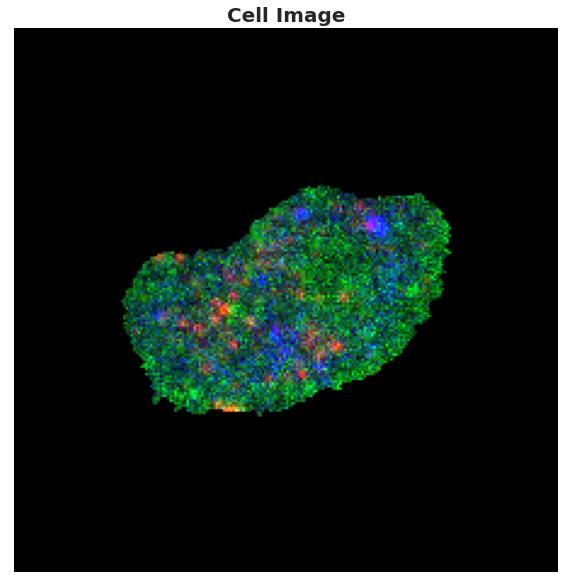

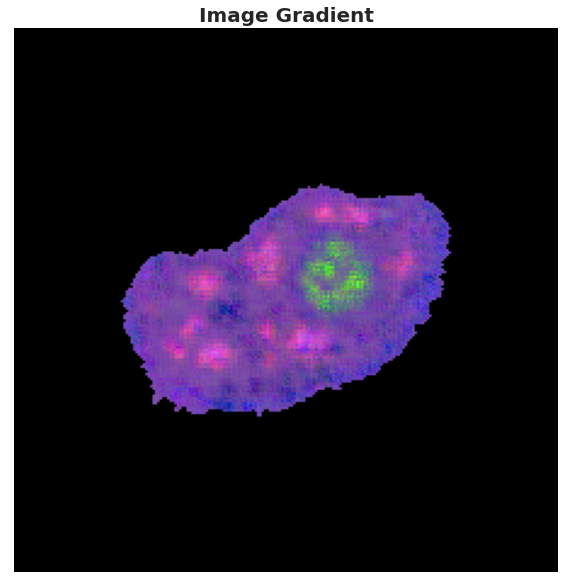

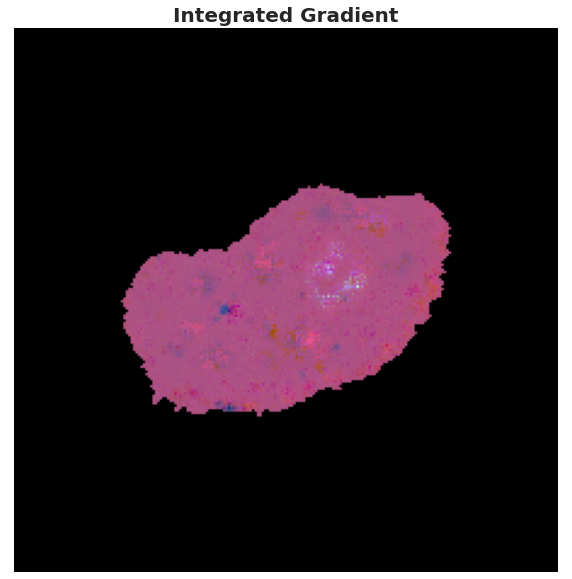

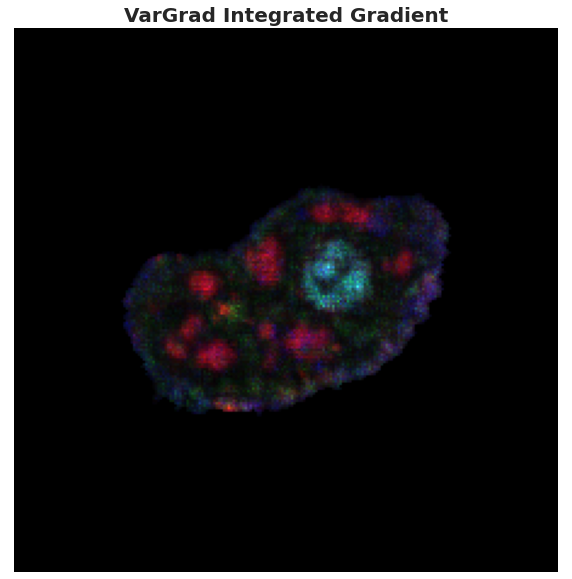

In [27]:
#img_grad
#c_id = np.array([11,12,13])
#c_id = np.array([4,5,22])
c_id = np.array([5,21, 32])

#c_id = 13
cmap = 'Blues'

images = [cell_img, img_grad, img_ig, img_VarGrad]
titles = ['Cell Image', 'Image Gradient', 'Integrated Gradient', 'VarGrad Integrated Gradient']
for img, title in zip(images, titles):
    plt.figure(figsize=(10,10))
    temp_img = normalize_img(img, cell_mask)
    plt.imshow(temp_img[:,:,c_id])#, cmap=getattr(plt.cm, cmap))
    plt.title(title, fontweight='bold', fontsize=20)
    plt.axis('equal')
    plt.grid(False)
    plt.axis(False)
    fig_name = "./" + "_".join(title.split(" ")) + ".jpg"
    plt.savefig(fig_name, bbox_inches='tight', pad_inches=0)